In [1]:
import kagglehub
import shutil

# Download dataset
uraninjo_augmented_alzheimer_mri_dataset_path = kagglehub.dataset_download('uraninjo/augmented-alzheimer-mri-dataset')

# Move the dataset to the /content directory
content_path = "/content/augmented-alzheimer-mri-dataset"
shutil.move(uraninjo_augmented_alzheimer_mri_dataset_path, content_path)

print(f'Dataset moved to: {content_path}')


100%|██████████| 380M/380M [00:06<00:00, 61.7MB/s]

Extracting files...


Dataset moved to: /content/augmented-alzheimer-mri-dataset


In [2]:
print(uraninjo_augmented_alzheimer_mri_dataset_path)


/root/.cache/kagglehub/datasets/uraninjo/augmented-alzheimer-mri-dataset/versions/1


In [3]:
import os
for dirname, _, filenames in os.walk('/content'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [4]:
import pandas as pd
import numpy as np
# import keras # Remove this line, we'll use tensorflow.keras instead
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# from keras.models import Sequential # Use tensorflow.keras instead
# from keras.layers import Dense, Dropout, Flatten # Use tensorflow.keras instead
# from keras.layers import Conv2D, MaxPooling2D # Use tensorflow.keras instead
# from keras import backend as K # Use tensorflow.keras instead

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Import from tensorflow.keras
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping

import sklearn.metrics as metrics
from tensorflow.keras.callbacks import LearningRateScheduler # Use tensorflow.keras
# from keras.preprocessing.image import ImageDataGenerator # Already imported above
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

In [5]:
import os
import pandas as pd

MildDemented_dir = r'/content/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset/MildDemented'
ModerateDemented_dir = r'/content/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset/ModerateDemented'
NonDemented_dir = r'/content/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset/NonDemented'
VeryMildDemented_dir = r'/content/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset/VeryMildDemented'

filepaths = []
labels = []
dict_list = [MildDemented_dir, ModerateDemented_dir, NonDemented_dir, VeryMildDemented_dir]
class_labels = ['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very MildDemented']

for i, j in enumerate(dict_list):
    flist = os.listdir(j)
    for f in flist:
        fpath = os.path.join(j, f)
        filepaths.append(fpath)
        labels.append(class_labels[i])

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
Alzheimer_data = pd.concat([Fseries, Lseries], axis=1)
Alzheimer_df = pd.DataFrame(Alzheimer_data)
print(Alzheimer_df.head())
print(Alzheimer_df["labels"].value_counts())

                                           filepaths         labels
0  /content/augmented-alzheimer-mri-dataset/Augme...  Mild Demented
1  /content/augmented-alzheimer-mri-dataset/Augme...  Mild Demented
2  /content/augmented-alzheimer-mri-dataset/Augme...  Mild Demented
3  /content/augmented-alzheimer-mri-dataset/Augme...  Mild Demented
4  /content/augmented-alzheimer-mri-dataset/Augme...  Mild Demented
labels
Non Demented         9600
Mild Demented        8960
Very MildDemented    8960
Moderate Demented    6464
Name: count, dtype: int64


In [6]:
Alzheimer_df.shape

(33984, 2)

In [7]:
train_images, test_images = train_test_split(Alzheimer_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(Alzheimer_df, test_size=0.2, random_state=42)

In [8]:
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

(27187, 2)
(10196, 2)
(6797, 2)
(23788, 2)


In [9]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=32,
                                      shuffle=False            #do not shuffle data
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=32,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=32,
                                    shuffle=False
                                   )

Found 27187 validated image filenames belonging to 4 classes.
Found 10196 validated image filenames belonging to 4 classes.
Found 6797 validated image filenames belonging to 4 classes.


In [10]:
classes=list(train.class_indices.keys())
print (classes)

['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very MildDemented']


In [11]:
def show_knee_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()

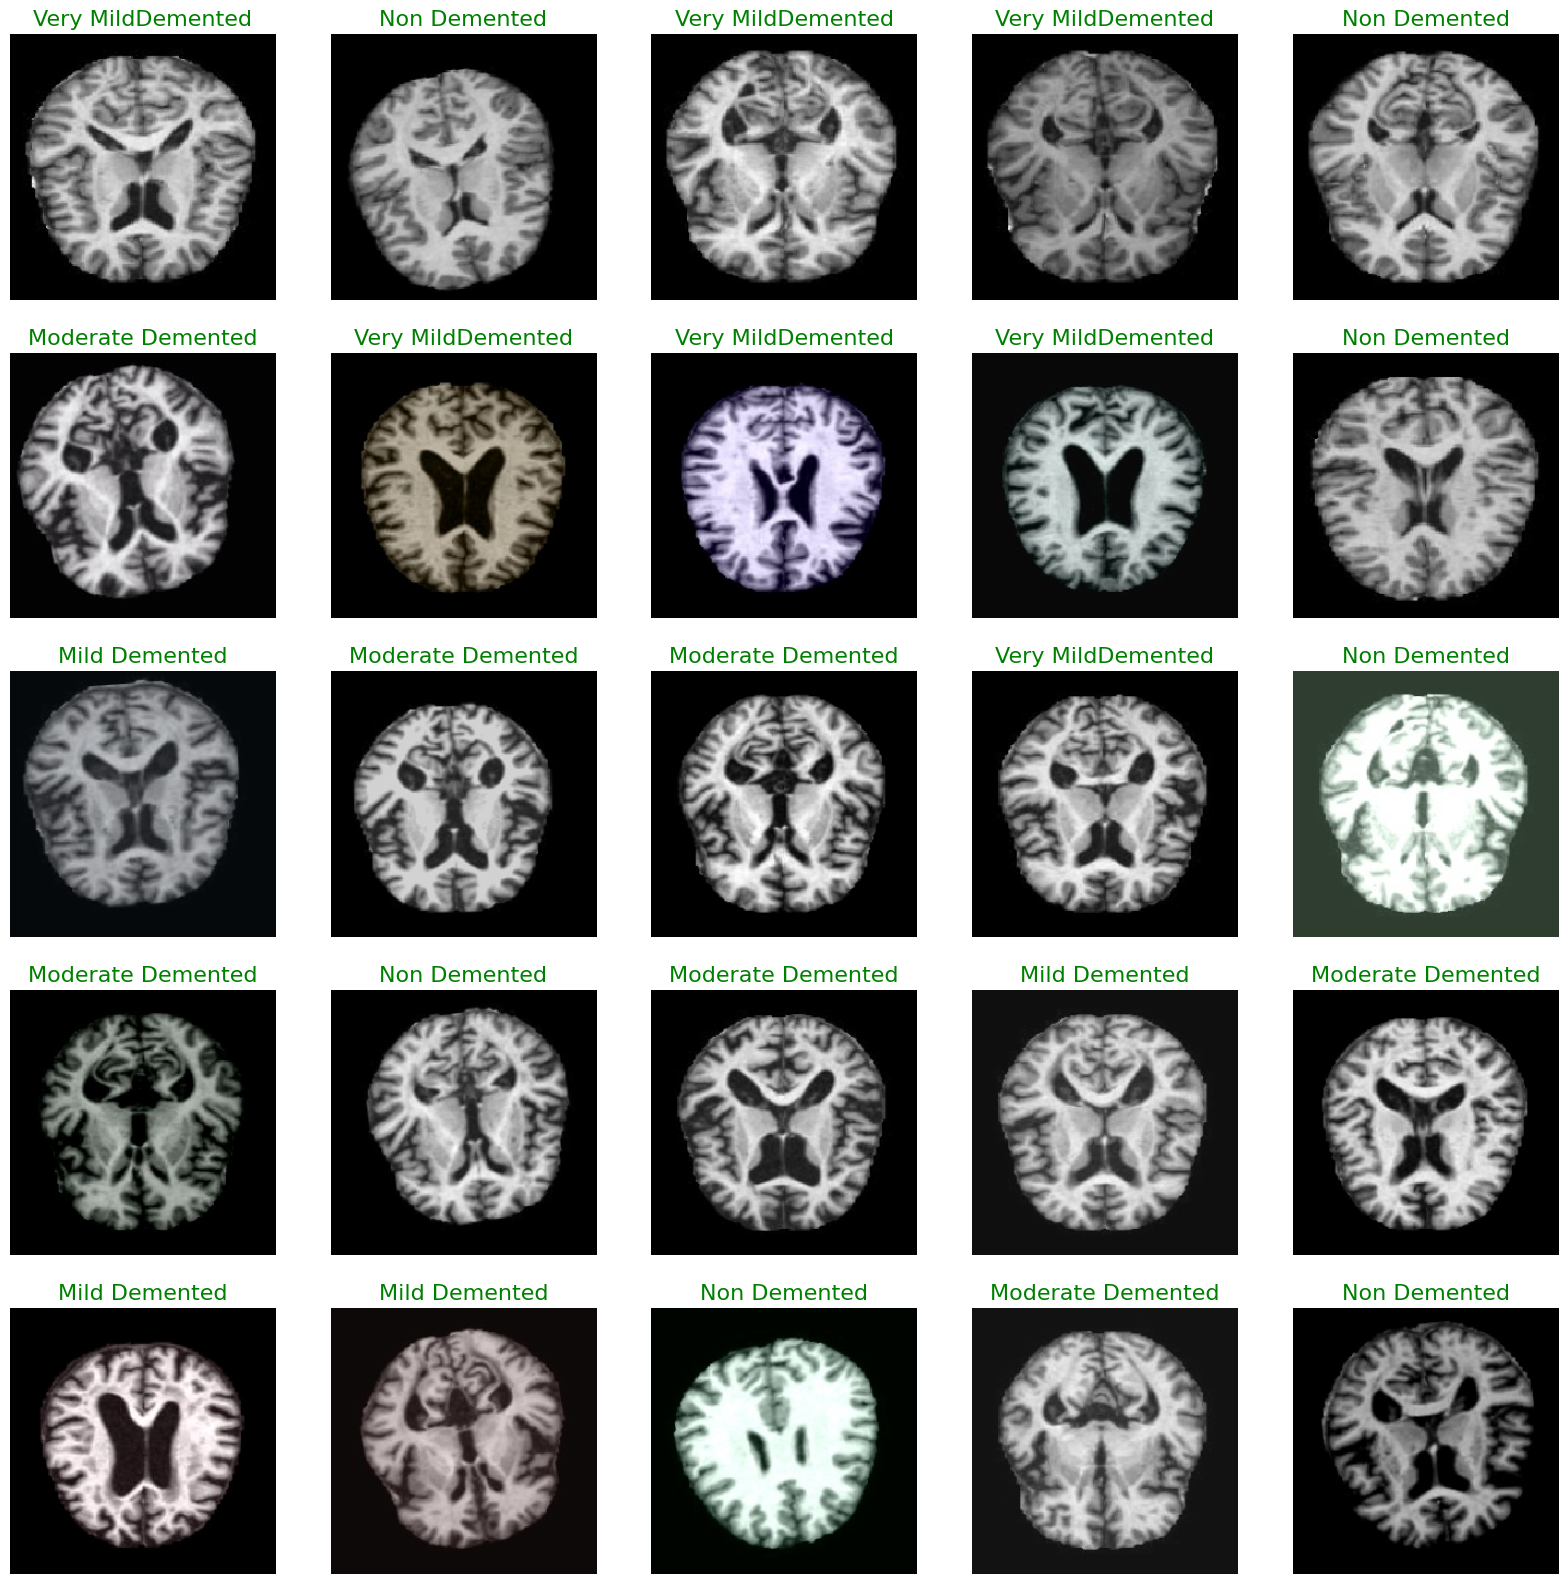

In [12]:
show_knee_images(train)

In [13]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(8, 8), strides=(3, 3), activation='relu', input_shape=(224, 224, 3)),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3, 3)),

    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 73, 73, 128)         │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 73, 73, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 73, 73, 256)         │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 73, 73, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 256)         │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 24, 24, 256)         │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 24, 24, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 24, 24, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 12, 12, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 12, 12, 512)         │           2,0

 Total params: 15,611,524 (59.55 MB)

 Trainable params: 15,605,124 (59.53 MB)

 Non-trainable params: 6,400 (25.00 KB)

In [14]:
history = model.fit(train, epochs=22, validation_data=val, validation_freq=1)

Epoch 1/22
850/850 ━━━━━━━━━━━━━━━━━━━━ 242s 249ms/step - accuracy: 0.3580 - loss: 1.7034 - val_accuracy: 0.5617 - val_loss: 0.9837
Epoch 2/22
850/850 ━━━━━━━━━━━━━━━━━━━━ 215s 221ms/step - accuracy: 0.5295 - loss: 1.0217 - val_accuracy: 0.6306 - val_loss: 0.8109
Epoch 3/22
850/850 ━━━━━━━━━━━━━━━━━━━━ 211s 232ms/step - accuracy: 0.6037 - loss: 0.8494 - val_accuracy: 0.6560 - val_loss: 0.7395
Epoch 4/22
850/850 ━━━━━━━━━━━━━━━━━━━━ 202s 232ms/step - accuracy: 0.6410 - loss: 0.7690 - val_accuracy: 0.6960 - val_loss: 0.6655
Epoch 5/22
850/850 ━━━━━━━━━━━━━━━━━━━━ 193s 221ms/step - accuracy: 0.6791 - loss: 0.6936 - val_accuracy: 0.7062 - val_loss: 0.6338
Epoch 6/22
850/850 ━━━━━━━━━━━━━━━━━━━━ 211s 232ms/step - accuracy: 0.7196 - loss: 0.6215 - val_accuracy: 0.7562 - val_loss: 0.5567
Epoch 7/22
850/850 ━━━━━━━━━━━━━━━━━━━━ 197s 227ms/step - accuracy: 0.7616 - loss: 0.5335 - val_accuracy: 0.7783 - val_loss: 0.5185
Epoch 8/22
850/850 ━━━━━━━━━━━━━━━━━━━━ 191s 224ms/step - accuracy: 0.8031 -

In [15]:
model.evaluate(test, verbose=1)

319/319 ━━━━━━━━━━━━━━━━━━━━ 31s 96ms/step - accuracy: 0.9078 - loss: 0.3181


[0.23388491570949554, 0.9332091212272644]

In [16]:
model.save("Osteoporosis_Model_binary.h5")

In [17]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

319/319 ━━━━━━━━━━━━━━━━━━━━ 25s 76ms/step


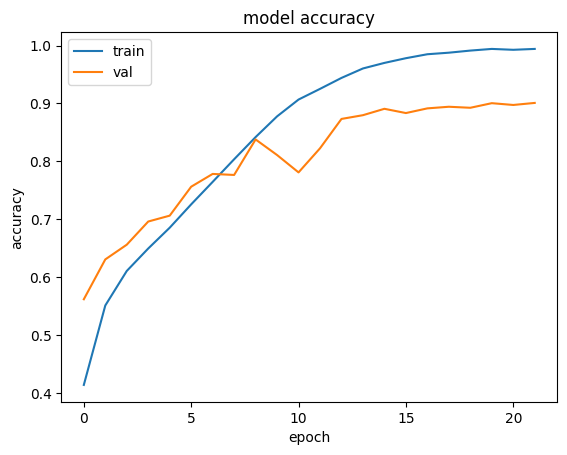

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

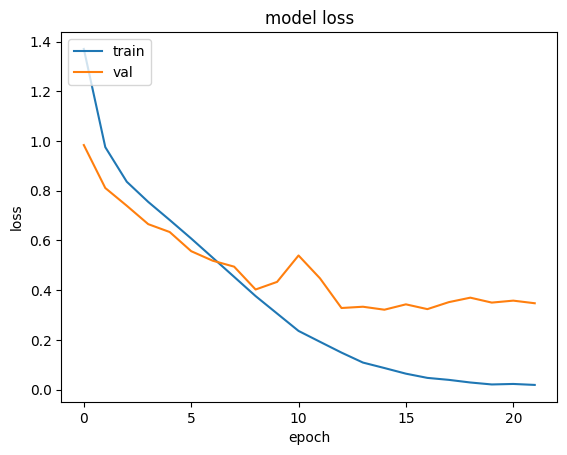

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [20]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_test = test_images.labels # set y_test to the expected output
print(classification_report(y_test, pred2))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred2)*100))

                   precision    recall  f1-score   support

    Mild Demented       0.94      0.94      0.94      2693
Moderate Demented       0.98      1.00      0.99      1977
     Non Demented       0.94      0.90      0.92      2811
Very MildDemented       0.89      0.91      0.90      2715

         accuracy                           0.93     10196
        macro avg       0.94      0.94      0.94     10196
     weighted avg       0.93      0.93      0.93     10196

Accuracy of the Model: 93.3%


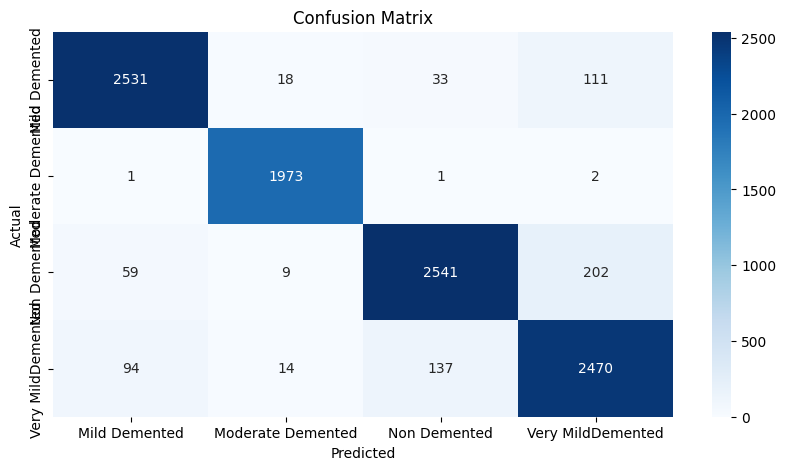

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define the class labels
class_labels = ['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very MildDemented']

# Calculate the confusion matrix
cm = confusion_matrix(y_test, pred2)

# Create a figure and plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

# Set tick labels and axis labels
plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Set the title
plt.title("Confusion Matrix")

# Show the plot
plt.show()

In [2]:
pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 676.4 kB/s eta 0:00:0000:0100:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 730.1 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 672.7 kB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Load the trained model
model = load_model('/Users/varunshukla07/Desktop/Alz/Pro/AlzModel.h5')

# Load and preprocess the MRI image
image_path = '/Users/varunshukla07/Desktop/Alz/Pro/image/example_image.jpg'
img = load_img(image_path, target_size=(224, 224))  # Adjust target size as per your model
img_array = img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Grad-CAM function
def grad_cam(model, img_array, layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, np.argmax(predictions[0])]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    return heatmap.numpy()

# Generate Grad-CAM heatmap
layer_name = "conv2d"  # Change this to the name of the last convolutional layer in your model
heatmap = grad_cam(model, img_array, layer_name)

# Overlay heatmap on the original image
heatmap = np.uint8(255 * heatmap)
heatmap = np.expand_dims(heatmap, axis=-1)
plt.imshow(img)
plt.imshow(heatmap, cmap="jet", alpha=0.5)  # Adjust alpha for transparency
plt.axis("off")
plt.show()


AttributeError: The layer sequential has never been called and thus has no defined output.

In [3]:
pip install torch torchvision matplotlib opencv-python numpy


  Using cached torch-2.5.1-cp312-none-macosx_11_0_arm64.whl.metadata (28 kB)
  Using cached torchvision-0.20.1-cp312-cp312-macosx_11_0_arm64.whl.metadata (6.1 kB)
  Using cached opencv_python-4.10.0.84-cp37-abi3-macosx_11_0_arm64.whl.metadata (20 kB)
  Using cached filelock-3.16.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
Using cached torch-2.5.1-cp312-none-macosx_11_0_arm64.whl (63.9 MB)
Using cached sympy-1.13.1-py3-none-any.whl (6.2 MB)
Using cached torchvision-0.20.1-cp312-cp312-macosx_11_0_arm64.whl (1.8 MB)
Using cached opencv_python-4.10.0.84-cp37-abi3-macosx_11_0_arm64.whl (54.8 MB)
Using cached filelock-3.16.1-py3-none-any.whl (16 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 736.8 kB/s eta 0:00:00a 0:00:01
Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip3 i

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the model
model_path = '/Users/varunshukla07/Desktop/Alz/Pro/AlzModel.h5'
model = load_model(model_path)

# Load and preprocess the image
img_path = '/Users/varunshukla07/Desktop/Alz/Pro/image/example_image.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize

# Run a dummy prediction to ensure layers are initialized
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions)

# Get the target convolutional layer
last_conv_layer_name = "conv2d_8"  # Replace with your layer name
last_conv_layer = model.get_layer(last_conv_layer_name)

# Build a model to map the input to the activations of the last conv layer and the predictions
grad_model = tf.keras.models.Model(
    inputs=model.input,
    outputs=[last_conv_layer.output, model.output]
)

# Compute the gradient of the top predicted class with respect to the activations of the last conv layer
with tf.GradientTape() as tape:
    last_conv_layer_output, preds = grad_model(img_array)
    tape.watch(last_conv_layer_output)
    class_channel = preds[:, predicted_class]

# Compute the gradient of the class output with respect to the feature map
grads = tape.gradient(class_channel, last_conv_layer_output)

# Pool the gradients over all the axes
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

# Multiply each channel in the feature map array by the pooled gradients
last_conv_layer_output = last_conv_layer_output[0]
heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer_output), axis=-1)

# Normalize the heatmap between 0 and 1 for visualization
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

# Visualize the heatmap
plt.imshow(heatmap, cmap='jet')
plt.colorbar()
plt.show()

# Overlay the heatmap on the original image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)

heatmap = np.expand_dims(heatmap, axis=-1)
heatmap = np.repeat(heatmap, 3, axis=-1)  # Convert to 3 channels
superimposed_img = heatmap * 0.4 + img_array  # Adjust transparency

plt.imshow(superimposed_img.astype('uint8'))
plt.axis('off')
plt.show()


FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/Users/varunshukla07/Desktop/Alz/Pro/AlzModel.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [6]:
# Print all layer names in your model
for layer in model.layers:
    print(layer.name)


conv2d
batch_normalization
conv2d_1
batch_normalization_1
max_pooling2d
conv2d_2
batch_normalization_2
conv2d_3
batch_normalization_3
conv2d_4
batch_normalization_4
conv2d_5
batch_normalization_5
max_pooling2d_1
conv2d_6
batch_normalization_6
conv2d_7
batch_normalization_7
max_pooling2d_2
conv2d_8
batch_normalization_8
max_pooling2d_3
flatten
dense
dropout
dense_1
dropout_1
dense_2


In [8]:
from tensorflow.keras.preprocessing import image
import numpy as np


model_path = '/Users/varunshukla07/Desktop/Alz/Pro/backend/AlzModel.h5'
model = load_model(model_path)
# Load a new image
img_path = '/Users/varunshukla07/Desktop/Alz/Pro/image/Non.jpg'  # Update with your new image path
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize

# Predict using the model
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions)

print(f"Predicted probabilities: {predictions}")
print(f"Predicted class: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
Predicted probabilities: [[4.4787247e-04 1.1222762e-04 9.9769551e-01 1.7443938e-03]]
Predicted class: 2


In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


In [11]:
# Load the trained model
model = tf.keras.models.load_model('/Users/varunshukla07/Desktop/Alz/Pro/backend/AlzModel.h5')

# Check the model summary to ensure it's loaded correctly
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 73, 73, 128)    │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 73, 73, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 73, 73, 256)    │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 73, 73, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 256)    │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 24, 24, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 6, 6, 512)      │         2,04

 Total params: 15,611,526 (59.55 MB)

 Trainable params: 15,605,124 (59.53 MB)

 Non-trainable params: 6,400 (25.00 KB)

 Optimizer params: 2 (12.00 B)

In [15]:
# Function to preprocess the image
def preprocess_image(img_path):
    # Load the image with the target size the model expects (e.g., 224x224)
    img = image.load_img(img_path, target_size=(224, 224))
    
    # Convert the image to a numpy array and normalize
    img_array = image.img_to_array(img) / 255.0  # Normalize if the model was trained with normalized images
    
    # Add an extra batch dimension
    img_array = np.expand_dims(img_array, axis=0)
    
    return img_array

# Path to the image you want to predict
img_path = '/Users/varunshukla07/Desktop/Alz/Pro/image/Moderate.jpg'

# Preprocess the image
img_array = preprocess_image(img_path)


In [16]:
# Get the model's prediction
prediction = model.predict(img_array)

# Assuming the model has 4 classes: 'Mild Demented', 'Moderate Demented', 'Non Demented', 'Very Mild Demented'
classes = ['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very Mild Demented']

# Get the predicted class (index of the highest score)
predicted_class_index = np.argmax(prediction)

# Display the prediction
print(f"Prediction: {classes[predicted_class_index]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Prediction: Non Demented


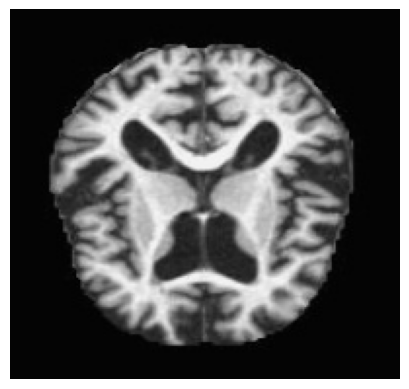

In [17]:
# Load the image using PIL and display it
img = Image.open(img_path)
plt.imshow(img)
plt.axis('off')  # Turn off axis numbers
plt.show()


In [ ]:
import os
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Define paths for your original dataset
original_dir = '/Users/varunshukla07/Desktop/Alz/Pro/Dataset/OriginalDataset'

# Image dimensions
img_width, img_height = 224, 224  # Use the size that your model was trained on

# Load your existing trained model
model = load_model('/Users/varunshukla07/Desktop/Alz/Pro/AlzModel.h5')

# Define ImageDataGenerators for loading and preprocessing images
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Use 20% of the original data for validation
)

validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Load data from the original dataset and apply the validation split
train_generator = train_datagen.flow_from_directory(
    original_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical',  # or 'binary' depending on your problem
    subset='training'  # Specify this is the training subset
)

validation_generator = validation_datagen.flow_from_directory(
    original_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical',  # or 'binary' depending on your problem
    subset='validation'  # Specify this is the validation subset
)

# Compile the model with a suitable optimizer and loss function
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Use a small learning rate when fine-tuning
    loss='categorical_crossentropy',  # or 'binary_crossentropy' for binary classification
    metrics=['accuracy']
)

# EarlyStopping to prevent overfitting (optional)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Train the model with the original dataset
history = model.fit(
    train_generator,
    epochs=10,  # Set the number of epochs as required
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

# Save the fine-tuned model
model.save('/Users/varunshukla07/Desktop/Alz/Pro/fine_tuned_model.h5')
/

Found 5121 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.
Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


161/161 ━━━━━━━━━━━━━━━━━━━━ 1530s 9s/step - accuracy: 0.6374 - loss: 1.0537 - val_accuracy: 0.5301 - val_loss: 1.0694
Epoch 2/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 1801s 11s/step - accuracy: 0.8428 - loss: 0.3837 - val_accuracy: 0.3643 - val_loss: 2.1493
Epoch 3/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 1829s 11s/step - accuracy: 0.9395 - loss: 0.1731 - val_accuracy: 0.5450 - val_loss: 1.4237
Epoch 4/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 1682s 10s/step - accuracy: 0.9733 - loss: 0.0802 - val_accuracy: 0.6372 - val_loss: 1.0650
Epoch 5/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 1675s 10s/step - accuracy: 0.9816 - loss: 0.0564 - val_accuracy: 0.6622 - val_loss: 1.1779
Epoch 6/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 1717s 11s/step - accuracy: 0.9923 - loss: 0.0277 - val_accuracy: 0.6755 - val_loss: 0.9127
Epoch 7/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 1644s 10s/step - accuracy: 0.9908 - loss: 0.0320 - val_accuracy: 0.6810 - val_loss: 0.9973
Epoch 8/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 1623s 10s/step - accuracy: 0.9862 - loss: 0.0427 - val_